In [ ]:
# ===== Cell 0/5: Basic imports, SDXL initialization, image and sampling utilities (including CLIP-77 safe truncation) =====
from pathlib import Path
import os, re, json, math, asyncio
from typing import List, Dict, Optional, Tuple

import torch
from PIL import Image
import nest_asyncio
nest_asyncio.apply()

from diffusers import (
    StableDiffusionXLPipeline,
    StableDiffusionXLImg2ImgPipeline,
    DPMSolverMultistepScheduler,
)

# -----------------------------
# 0) SDXL setup
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if torch.cuda.is_available() else torch.float32
SDXL_ID = "stabilityai/stable-diffusion-xl-base-1.0"

print(f"[Init] DEVICE={DEVICE} DTYPE={DTYPE} SDXL_ID={SDXL_ID}")

SDXL_base = StableDiffusionXLPipeline.from_pretrained(SDXL_ID, torch_dtype=DTYPE).to(DEVICE)
SDXL_i2i  = StableDiffusionXLImg2ImgPipeline.from_pretrained(SDXL_ID, torch_dtype=DTYPE).to(DEVICE)
for p in (SDXL_base, SDXL_i2i):
    try:
        p.enable_vae_slicing(); p.enable_attention_slicing()
    except Exception:
        pass
    p.scheduler = DPMSolverMultistepScheduler.from_config(p.scheduler.config, use_karras_sigmas=True)

DEFAULT_NEG = (
    "blurry, low quality, artifacts, watermark, extra fingers, missing limbs, "
    "over-sharpened, harsh lighting, oversaturated"
)

@torch.no_grad()
def decode_image_sdxl(latents: torch.Tensor, pipe: StableDiffusionXLImg2ImgPipeline, output_type="pil"):
    # Decode latents using the VAE decoder of the pipeline
    vae = pipe.vae
    needs_upcast = (vae.dtype in (torch.float16, torch.bfloat16)) and bool(getattr(vae.config, "force_upcast", False))
    if needs_upcast:
        try:
            pipe.upcast_vae()
        except Exception:
            pipe.vae = pipe.vae.to(torch.float32)
        vae = pipe.vae
    lat = latents.to(device=vae.device, dtype=(next(vae.post_quant_conv.parameters()).dtype))
    lat = lat / vae.config.scaling_factor
    out = vae.decode(lat)
    x = out[0] if isinstance(out, (list, tuple)) else (out.sample if hasattr(out, "sample") else out)
    if getattr(pipe, "watermark", None) is not None:
        x = pipe.watermark.apply_watermark(x)
    return pipe.image_processor.postprocess(x.detach(), output_type=output_type)[0]

@torch.no_grad()
def base_sample_latent(prompt: str, seed: int = 2025, H: int = 1024, W: int = 1024, neg: str = ""):
    # Generate a latent image from a base prompt
    g = torch.Generator(device=DEVICE).manual_seed(int(seed))
    out = SDXL_base(
        prompt=prompt, negative_prompt=neg, height=H, width=W,
        guidance_scale=4.5, num_inference_steps=50, generator=g,
        output_type="latent"
    )
    z0 = out.images
    x0 = decode_image_sdxl(z0, SDXL_i2i)
    return z0, x0

@torch.no_grad()
def img2img_latent(prompt: str, image_or_latent, strength: float, guidance: float, steps: int, seed: int):
    # Perform latent-space img2img given a prompt and latent/image input
    g = torch.Generator(device=DEVICE).manual_seed(int(seed))
    out = SDXL_i2i(
        prompt=prompt, image=image_or_latent, strength=float(strength),
        guidance_scale=float(guidance), num_inference_steps=int(steps),
        generator=g, output_type="latent", negative_prompt=DEFAULT_NEG
    )
    return out.images

def strength_for_last_k(k: int, total_steps: int) -> float:
    # Convert a final k-step correction into img2img strength
    k = max(1, int(k))
    return min(0.95, max(0.01, float(k) / float(max(1, total_steps))))

# ---- CLIP-77 Token Helper ----
import re
try:
    from transformers import CLIPTokenizerFast
    _clip_tok = CLIPTokenizerFast.from_pretrained("openai/clip-vit-large-patch14")
    def _count_tokens(txt: str) -> int:
        return len(_clip_tok(txt, add_special_tokens=True, truncation=False)["input_ids"])
except Exception:
    _clip_tok = None
    def _count_tokens(txt: str) -> int:
        return int(len(re.findall(r"\w+", txt)) * 1.3)

def _cleanup_commas(s: str) -> str:
    s = re.sub(r'\s*,\s*', ', ', s.strip())
    s = re.sub(r',\s*,+', ', ', s)
    return s.strip(' ,')

def clip77_strict(text: str, max_tok: int = 77) -> str:
    # Truncate text to fit within 77 CLIP tokens
    if _count_tokens(text) <= max_tok:
        return text.strip()
    words = text.strip().split()
    lo, hi, best = 0, len(words), ""
    while lo <= hi:
        mid = (lo + hi) // 2
        cand = " ".join(words[:mid]) if mid > 0 else ""
        if _count_tokens(cand) <= max_tok:
            best = cand; lo = mid + 1
        else:
            hi = mid - 1
    return best.strip()


[Init] DEVICE=cuda DTYPE=torch.float16 SDXL_ID=stabilityai/stable-diffusion-xl-base-1.0


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
os.environ.setdefault(
    "TOGETHER_API_KEY",
    os.environ.get("TOGETHER_API_KEY", "53f264beb1059eb3c141349ac73c2c362d61497f5cc07568549e37f2c8d3b0c8")
)


'53f264beb1059eb3c141349ac73c2c362d61497f5cc07568549e37f2c8d3b0c8'

In [17]:
# -*- coding: utf-8 -*-
# Cell 1/5: 共用設定、型別、工具函式（token/清理/順序/影像編碼）

from __future__ import annotations
from typing import Dict, List, Tuple, Optional, Iterable, Set
from pathlib import Path
import os, io, re, json, asyncio, inspect, base64
from PIL import Image

import torch
import torch.nn as nn

# 若外部沒提供，設定預設裝置
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============ 小工具 ============
def _cleanup_commas(s: str) -> str:
    s = re.sub(r"\s*,\s*", ", ", s.strip())
    s = re.sub(r"(,\s*){2,}", ", ", s)
    return s.strip(" ,")

def _count_tokens(s: str) -> int:
    # 粗略估計；真正壓 77 請交給 clip77_strict（外部提供）
    return len(re.findall(r"\w+|\S", s))

def _split_tags(s: str) -> List[str]:
    return [p.strip() for p in re.split(r",|\n", s.strip()) if p.strip()]

def _split_tags_relaxed(s: str) -> List[str]:
    if not s: return []
    return [p.strip() for p in re.split(r"[,\n]+", s) if p.strip()]

def _dedup_keep_order(items: List[str]) -> List[str]:
    seen, out = set(), []
    for t in items:
        key = re.sub(r"\s+", " ", t.lower()).strip()
        if key and key not in seen:
            seen.add(key); out.append(t.strip())
    return out

def _order_tags(subject_first: List[str], rest: List[str]) -> List[str]:
    # 讓主題在最前，其餘依大類粗分
    buckets = {"subject": [], "style": [], "composition": [], "lighting": [], "color": [], "detail": [], "other": []}
    style_kw = ("style","painterly","illustration","photorealistic","neon","poster","matte painting","watercolor","cyberpunk")
    comp_kw  = ("composition","rule of thirds","centered","symmetry","balanced composition")
    light_kw = ("lighting","light","glow","glowing","aura","rim","sunset","sunrise","golden hour","global illumination","cinematic")
    color_kw = ("color","palette","vibrant","muted","monochrome","pastel","warm","cool","balanced contrast")
    detail_kw= ("detailed","hyperdetailed","texture","textured","intricate","high detail","highly detailed","sharp focus","UHD","8k")
    for t in subject_first: buckets["subject"].append(t)
    for t in rest:
        lt = t.lower()
        if   any(k in lt for k in style_kw): buckets["style"].append(t)
        elif any(k in lt for k in comp_kw):  buckets["composition"].append(t)
        elif any(k in lt for k in light_kw): buckets["lighting"].append(t)
        elif any(k in lt for k in color_kw): buckets["color"].append(t)
        elif any(k in lt for k in detail_kw):buckets["detail"].append(t)
        else:                                buckets["other"].append(t)
    return buckets["subject"] + buckets["style"] + buckets["composition"] + buckets["lighting"] + buckets["color"] + buckets["detail"] + buckets["other"]

def pil_to_base64(img: Image.Image, fmt: str = "PNG") -> str:
    buf = io.BytesIO(); img.save(buf, format=fmt)
    return base64.b64encode(buf.getvalue()).decode("ascii")

async def _maybe_close_async_together(client) -> None:
    try:
        if hasattr(client, "aclose") and inspect.iscoroutinefunction(client.aclose):
            await client.aclose()
        elif hasattr(client, "close"):
            fn = client.close
            if inspect.iscoroutinefunction(fn):
                await fn()
            else:
                try: fn()
                except Exception: pass
    except Exception:
        pass

# 依使用者短語自動加 0–2 個輕量風格提示（不強制）
STYLE_RULES: List[Tuple[str, List[str]]] = [
    (r"\bphoto(graph|real| realistic)?\b|\bportrait\b|\brealistic\b", ["photorealistic","dslr look"]),
    (r"\bpainting|oil|canvas|brush|painterly\b", ["painterly","brush strokes"]),
    (r"\bposter|cinematic|film|movie\b", ["cinematic composition","matte painting"]),
    (r"\banime|manga|chibi|kawaii\b", ["clean line art","illustration"]),
    (r"\bwatercolor\b", ["watercolor"]),
    (r"\bcyberpunk|neon\b", ["neon lights","cyberpunk"]),
]

def _auto_style_hints(user_prompt: str) -> List[str]:
    hints: List[str] = []
    up = user_prompt.lower()
    for pattern, tags in STYLE_RULES:
        if re.search(pattern, up):
            for t in tags:
                if len(hints) < 2 and t not in hints:
                    hints.append(t)
    return hints


In [18]:
# Cell 2/5: CritiCore（Multi-LLM / VLM 文字修飾與聚合）

from typing import Any
from together import AsyncTogether
from together.error import InvalidRequestError, RateLimitError

# 可用環境變數覆寫
AGGREGATOR_MODEL = os.environ.get("AGGREGATOR_MODEL", "Qwen/Qwen2.5-72B-Instruct-Turbo")

# 預設參與 Multi-LLM 的大語言模型（可依環境調整）
LLM_MULTI_CANDIDATES = [
    "meta-llama/Llama-3.3-70B-Instruct-Turbo",
    "Qwen/Qwen2.5-72B-Instruct-Turbo",
    "Qwen/Qwen2.5-Coder-32B-Instruct",
    "deepseek-ai/DeepSeek-V3",
    "nvidia/NVIDIA-Nemotron-Nano-9B-v2",
]

# 預設參與 VLM 批改的候選（可透過環境變數 VLM_MOA_CANDIDATES 覆蓋）
_env_list = [s.strip() for s in os.environ.get("VLM_MOA_CANDIDATES","").split(",") if s.strip()]
VLM_CANDIDATES: List[str] = _env_list or [
    "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8"
]

# Text presets（不鎖風格，偏好高畫質美學）
TAG_PRESETS = {
    "hq_preference": {
        "seed_pos": [
            "balanced composition",
            "natural color palette","vibrant colors","balanced contrast",
            "high detail","highly detailed","hyperdetailed","sharp focus",
            "UHD","8k"
        ],
        "seed_neg": [
            "low quality","blurry","watermark","jpeg artifacts","overexposed","underexposed",
            "color banding","extra fingers","missing limbs","disfigured","mutated hands"
        ]
    }
}

_DECOMP_SYS = (
    "Decompose the user's visual instruction into 3-6 concrete, checkable visual components "
    "(entities + interactions + spatial relations). Return ONLY JSON: "
    '{"components":["..."]}'
)

_TXT_SYS = (
    "Expand a VERY SHORT visual idea into a COMMA-SEPARATED TAG LIST for SDXL.\n"
    "Constraints:\n"
    "- Start with the subject phrase first.\n"
    "- Prioritize composition, lighting, color, and detail over style.\n"
    "- Use at most TWO style tags if any.\n"
    "- 16–26 concise tags total. Commas only, no sentences, no 'and'. No trailing period.\n"
    "- Prefer human-preference aesthetics; keep 'high detailed', 'sharp focus', '8k', 'UHD'."
)

def _TAG_RE(tag: str):
    return re.compile(rf"<\s*{tag}\s*>(.*?)</\s*{tag}\s*>", re.S|re.I)

def _extract_tag(text: str, tag: str, fallback: str = "") -> str:
    s = (text or "").strip()
    r = _TAG_RE(tag); m = r.search(s)
    if m: return m.group(1).strip()
    s2 = s.replace("&lt;","<").replace("&gt;",">"); m2 = r.search(s2)
    return m2.group(1).strip() if m2 else fallback.strip()

def _summarize_issues_lines(text: str, max_lines: int = 5) -> str:
    if not text: return ""
    parts = [p.strip(" -•\t") for p in re.split(r"[\n;]+", text) if p.strip()]
    parts = parts[:max_lines]
    return "\n".join(f"- {p}" for p in parts)

class CritiCore:
    """
    Multi-LLM（原 MoA）產生 tag/neg 與構件分解；VLM 多模型批改並聚合；提供融合工具。
    依賴：clip77_strict、AsyncTogether（TOGETHER_API_KEY）
    """
    def __init__(self, preset: str = "hq_preference", aggregator_model: str = AGGREGATOR_MODEL):
        if not os.environ.get("TOGETHER_API_KEY"):
            raise RuntimeError("Missing TOGETHER_API_KEY.")
        self.preset = preset
        self.aggregator = aggregator_model

    # ---------- Multi-LLM：概念分解 ----------
    async def decompose_components(self, user_prompt: str) -> List[str]:
        client = AsyncTogether(api_key=os.environ["TOGETHER_API_KEY"])
        try:
            # 並行呼叫
            tasks = [client.chat.completions.create(
                model=m,
                messages=[{"role":"system","content": _DECOMP_SYS},
                          {"role":"user","content": user_prompt}],
                temperature=0.4, max_tokens=256
            ) for m in LLM_MULTI_CANDIDATES]
            rs = await asyncio.gather(*tasks, return_exceptions=True)
            texts = []
            for r in rs:
                try:
                    texts.append(r.choices[0].message.content)
                except Exception:
                    pass
            if not texts: return []
            joined = "\n\n---\n\n".join(texts)
            merged = await client.chat.completions.create(
                model=self.aggregator,
                messages=[{"role":"system","content": "Merge JSON candidates and return ONLY {'components':[...]}."},
                          {"role":"user","content": joined}],
                temperature=0.2, max_tokens=256
            )
            txt = merged.choices[0].message.content
            try:
                obj = json.loads(txt)
            except Exception:
                s,e = txt.find("{"), txt.rfind("}")
                obj = json.loads(txt[s:e+1]) if (s!=-1 and e!=-1) else {"components":[]}
            comps = [c.strip() for c in obj.get("components", []) if isinstance(c, str) and c.strip()]
            return comps[:6]
        finally:
            await _maybe_close_async_together(client)

    # ---------- Multi-LLM：產生 tags（pos/neg） ----------
    async def make_tags(self, user_prompt: str, clip77: bool = True) -> Tuple[str, str]:
        client = AsyncTogether(api_key=os.environ["TOGETHER_API_KEY"])
        seed = TAG_PRESETS.get(self.preset, TAG_PRESETS["hq_preference"])
        auto_style = _auto_style_hints(user_prompt)
        seed_pos = _dedup_keep_order(seed["seed_pos"] + auto_style)
        seed_neg = seed["seed_neg"]
        try:
            # 多模型提案
            tasks = [client.chat.completions.create(
                model=m,
                messages=[{"role":"system","content": _TXT_SYS},
                          {"role":"user","content": f"Short idea: {user_prompt}\nSeed: {', '.join(seed_pos)}\nOutput: a single comma-separated tag list."}],
                temperature=0.7, max_tokens=220
            ) for m in LLM_MULTI_CANDIDATES]
            rs = await asyncio.gather(*tasks, return_exceptions=True)
            props = []
            for r in rs:
                try:
                    props.append(r.choices[0].message.content)
                except Exception:
                    pass
            if not props:
                pos = ", ".join([user_prompt.strip()] + seed_pos)
            else:
                joined = "\n---\n".join(props)
                merged = await client.chat.completions.create(
                    model=self.aggregator,
                    messages=[{"role":"system","content":
                               "Merge candidate tag lists into ONE comma list (16–26 tags). Subject first; at most TWO style tags; keep high detailed/sharp focus/8k/UHD."},
                              {"role":"user","content": joined}],
                    temperature=0.2, max_tokens=240
                )
                raw = merged.choices[0].message.content
                tags = _dedup_keep_order(_split_tags(raw))
                subject = user_prompt.strip().rstrip(",.")
                if subject and not any(subject.lower() == t.lower() for t in tags):
                    tags = [subject] + tags
                ordered = _order_tags([tags[0]], tags[1:])
                pos = ", ".join(_dedup_keep_order(ordered))
            # 基線畫質詞保障
            QUALITY_FLOOR = ["high detailed","sharp focus","8k","UHD"]
            have = {t.lower() for t in _split_tags(pos)}
            for q in QUALITY_FLOOR:
                if q.lower() not in have:
                    pos += ", " + q
            pos = _cleanup_commas(pos)
            if clip77 and _count_tokens(pos) > 77:
                pos = clip77_strict(pos, 77)
            neg = ", ".join(seed_neg)
            return pos, neg
        finally:
            await _maybe_close_async_together(client)

    # ---------- VLM 多模型批改與聚合 ----------
    async def vlm_refine(self, image: Image.Image, original_prompt: str, components: List[str]) -> Dict[str, Any]:
        client = AsyncTogether(api_key=os.environ["TOGETHER_API_KEY"])
        b64 = pil_to_base64(image, "PNG")
        def _user_prompt_text() -> str:
            return (
                "You are a precise image-grounded critic.\n"
                "1) List concrete visual problems and brief corrections.\n"
                "2) Provide a refined prompt that keeps the original intent.\n\n"
                f'Original prompt: "{original_prompt}"\n'
                f"Key components to check: {components}\n"
                "Output EXACTLY two tags:\n"
                "<issues>...</issues>\n<refined>...</refined>"
            )
        try:
            # 並行呼叫 VLM 候選
            tasks = []
            for m in VLM_CANDIDATES:
                msgs = [
                    {"role":"system","content": "Return ONLY <issues> and <refined>. No extra text."},
                    {"role":"user","content": [
                        {"type":"text","text": _user_prompt_text()},
                        {"type":"image_url","image_url":{"url": f"data:image/png;base64,{b64}"}}
                    ]}
                ]
                tasks.append(client.chat.completions.create(model=m, messages=msgs, temperature=0.2, max_tokens=420))
            rs = await asyncio.gather(*tasks, return_exceptions=True)
            ok = []
            for m, r in zip(VLM_CANDIDATES, rs):
                try:
                    raw = r.choices[0].message.content
                    ok.append((m, raw))
                except Exception:
                    pass
            if not ok:
                return {"refined": original_prompt, "used_models": [], "per_vlm_refined_77": {}, "per_vlm_issues": {}, "issues_merged": ""}

            # 抽取每家 <issues>/<refined>
            refined_items, per_vlm_issues, all_raw = [], {}, {}
            for m, raw in ok:
                all_raw[m] = raw
                issues = _extract_tag(raw, "issues", "")
                refined = _extract_tag(raw, "refined", original_prompt)
                if refined.strip(): refined_items.append((m, refined.strip()))
                if issues.strip():  per_vlm_issues[m] = _summarize_issues_lines(issues, 5)

            per_vlm_refined_77 = {}
            for m, txt in refined_items:
                try:
                    per_vlm_refined_77[m] = clip77_strict(txt, 77)
                except Exception:
                    per_vlm_refined_77[m] = original_prompt

            # 聚合成最終 refined + issues
            joined_issues  = "\n".join(f"[{m}] {t}" for m,t in per_vlm_issues.items())
            joined_refined = "\n".join(f"[{m}] {t}" for m,t in refined_items) if refined_items else original_prompt
            merged = await client.chat.completions.create(
                model=self.aggregator,
                messages=[{"role":"system","content":
                           "Merge multiple critics. Output ONLY <issues> (≤5 bullets) and <refined> (≤70 words, no camera/gear/resolution jargon)."},
                          {"role":"user","content": f"{joined_issues}\n\n----\n\n{joined_refined}"}],
                temperature=0.2, max_tokens=420
            )
            final_raw = merged.choices[0].message.content
            final_refined = _extract_tag(final_raw, "refined", original_prompt)
            final_refined = clip77_strict(final_refined, 77)
            issues_merged = _summarize_issues_lines(_extract_tag(final_raw, "issues", ""), 5)

            return {
                "refined": final_refined,
                "used_models": [m for m,_ in refined_items],
                "per_vlm_refined_77": per_vlm_refined_77,
                "per_vlm_issues": per_vlm_issues,
                "issues_merged": issues_merged
            }
        finally:
            await _maybe_close_async_together(client)

    # ---------- 文字融合（VLM refined + Multi-LLM tags） ----------
    @staticmethod
    def merge_vlm_multi_text(vlm_refined_77: str, tags_77: str) -> str:
        vlm_tags = _split_tags(vlm_refined_77)
        moa_tags = _split_tags(tags_77)
        merged = _dedup_keep_order(_order_tags([vlm_tags[0] if vlm_tags else ""], (vlm_tags[1:] + moa_tags)))
        merged = [t for t in merged if t]
        text = _cleanup_commas(", ".join(merged))
        if _count_tokens(text) > 77:
            text = clip77_strict(text, 77)
        return text


In [38]:
# Cell 3/5: SpecFusion（CADR 參數映射 + 頻域融合 + 最終修正）

def _clamp01(x: float) -> float: return max(0.0, min(1.0, float(x)))
def _lerp(a: float, b: float, t: float) -> float: return a + (b - a) * t

class SpecFusion:
    """
    將 CADR（依 alignment 映射 img2img 參數）與頻域融合整合，產出 fused latent 與影像。
    依賴：SDXL_i2i（需支援 output_type='latent'）、decode_image_sdxl。
    """
    def __init__(self, device: Optional[torch.device] = None):
        self.device = device or DEVICE

    @staticmethod
    def cadr_from_alignment(align_score: float) -> Tuple[float, float, int, float]:
        """
        alignment: 0..100。越低→修正越強（較大 strength/guidance/steps；較高 rho_t）
        回傳：(strength, guidance, steps, rho_t)
        """
        s = _clamp01(align_score / 100.0); mis = 1.0 - s
        strength = _lerp(0.12, 0.30, mis)
        guidance = _lerp(3.6,  5.0,  mis)
        steps    = int(round(_lerp(16, 30, mis)))
        rho_t    = _lerp(0.60, 0.85, mis)
        return strength, guidance, steps, rho_t

    @torch.no_grad()
    def frequency_fusion(self,
                         x_hi_latent: torch.Tensor,
                         x_lo_latent: torch.Tensor,
                         base_c: float = 0.5,
                         rho_t: float = 0.8) -> torch.Tensor:
        """
        低頻保留 base（lo），高頻取 refined（hi）；中央矩形域以 rho_t 衰減。
        """
        B,C,H,W = x_hi_latent.shape
        x_h = x_hi_latent.to(torch.float32); x_l = x_lo_latent.to(torch.float32)

        Xh = torch.fft.fftshift(torch.fft.fftn(x_h, dim=(-2,-1)), dim=(-2,-1))
        Xl = torch.fft.fftshift(torch.fft.fftn(x_l, dim=(-2,-1)), dim=(-2,-1))

        tau_h = int(H * base_c * (1 - rho_t))
        tau_w = int(W * base_c * (1 - rho_t))
        mask  = torch.ones((B,C,H,W), device=self.device, dtype=torch.float32)
        cy, cx = H//2, W//2
        mask[..., cy-tau_h:cy+tau_h, cx-tau_w:cx+tau_w] = rho_t  # 中低頻衰減係數

        Xf = Xh * mask + Xl * (1 - mask)
        x  = torch.fft.ifftn(torch.fft.ifftshift(Xf, dim=(-2,-1)), dim=(-2,-1)).real
        x += torch.randn_like(x) * 0.001
        return x.to(dtype=x_hi_latent.dtype)

    @torch.no_grad()
    def final_touch(self,
                    enhanced_prompt: str,
                    base_latent: torch.Tensor,
                    align_score: Optional[float] = None,
                    seed: int = 2025) -> Tuple[torch.Tensor, Image.Image, Dict[str, float]]:
        """
        將 enhanced_prompt 套 CADR → img2img（latent）→ 頻域融合 → decode。
        若 align_score 為 None，會回傳需要你外部先行計算（本函式不幫你估）。
        """
        if align_score is None:
            raise ValueError("SpecFusion.final_touch 需要 align_score（建議由 pref_score 或外部評分提供）。")

        strength, guidance, steps, rho_t = self.cadr_from_alignment(float(align_score))
        g = torch.Generator(device=self.device).manual_seed(seed)

        out = SDXL_i2i(
            prompt=enhanced_prompt,
            image=base_latent,
            strength=strength,
            num_inference_steps=steps,
            guidance_scale=guidance,
            generator=g,
            output_type="latent",
        )
        lat_refined = out.images
        fused = self.frequency_fusion(lat_refined, base_latent, base_c=0.5, rho_t=rho_t)
        decoded = decode_image_sdxl(fused, SDXL_i2i)
        img = decoded.images[0] if hasattr(decoded, "images") else decoded

        return fused, img, dict(strength=strength, guidance=guidance, steps=steps, rho_t=0.9)


In [39]:
# Cell 4/5: 單一路徑 pipeline（Base → CritiCore → SpecFusion）

async def pipeline_base_vlm_multi_cadr(
    user_prompt: str,
    seed: int = 2026,
    H: int = 1024, W: int = 1024,
    preset: str = "hq_preference",
    align_score: Optional[float] = None,   # 若未提供，可用外部 pref_score 計算後再傳入
    save_dir: Optional[Path] = None,
) -> Dict[str, object]:
    """
    步驟：
      1) Base(no Multi-LLM) 生成 (z0_base, base_img)
      2) CritiCore：Multi-LLM 產生 tags；VLM 聚合 refined；兩者融合→ enhanced_prompt_77
      3) 若未提供 align_score，可先以外部 pref_score(enhanced_prompt, base_img) 推估
      4) SpecFusion：依 CADR 做一次 img2img（latent）+ 頻域融合 → cadr_img
    回傳：影像、文字、latent 與 CADR 參數；可選寫檔。
    """
    critic = CritiCore(preset=preset)
    spec   = SpecFusion(device=DEVICE)

    # (1) Base（no tags）
    z0_base, base_img = base_sample_latent(user_prompt, seed=seed, H=H, W=W, neg=DEFAULT_NEG)

    # (2) CritiCore：Multi-LLM tags + VLM refined + 融合
    pos_tags_77, neg_tags = await critic.make_tags(user_prompt, clip77=True)
    components = await critic.decompose_components(user_prompt)
    vlm_out    = await critic.vlm_refine(base_img, user_prompt, components or [])
    vlm_ref_77 = vlm_out.get("refined") or user_prompt
    enhanced_77 = CritiCore.merge_vlm_multi_text(vlm_ref_77, pos_tags_77)

    # (3) alignment：若未外給，建議用 pref_score（0..1）轉 0..100
    if align_score is None:
        try:
            align_score = float(pref_score(enhanced_77, base_img) * 100.0)
        except Exception:
            align_score = 60.0

    # (4) SpecFusion（CADR + 頻域融合）
    fused_latent, cadr_img, cadr_params = spec.final_touch(
        enhanced_prompt=enhanced_77,
        base_latent=z0_base,
        align_score=align_score,
        seed=seed + 999
    )

    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)
        base_img.save(save_dir / "base_no_multi.png")
        cadr_img.save(save_dir / "cadr_final.png")
        with open(save_dir / "record.json", "w", encoding="utf-8") as f:
            json.dump({
                "user_prompt": user_prompt,
                "pos_tags_77": pos_tags_77,
                "vlm_refined_77": vlm_ref_77,
                "enhanced_prompt_77": enhanced_77,
                "align_score": align_score,
                "cadr_params": cadr_params,
                "components": components,
                "vlm_issues": vlm_out.get("issues_merged",""),
            }, f, ensure_ascii=False, indent=2)

    return {
        "user_prompt": user_prompt,
        "base_img": base_img,
        "z0_base": z0_base,
        "pos_tags_77": pos_tags_77,
        "vlm_refined_77": vlm_ref_77,
        "enhanced_prompt_77": enhanced_77,
        "align_score": align_score,
        "cadr_img": cadr_img,
        "fused_latent": fused_latent,
        "cadr_params": cadr_params,
        "components": components,
    }


In [45]:
from typing import Dict, List, Tuple, Optional, Iterable, Set
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import asyncio

# ───────── Variant names / display order / legend ─────────
VARIANT_LABELS = {
    "base_multi_llm":                     "1_base_multi_llm",
    "criticore_on_multi_llm__specfusion": "2_criticore_on_multi_llm__specfusion",
    "base_original":                      "3_base_original",
    "criticore_on_original__specfusion":  "4_criticore_on_original__specfusion",
}
VARIANT_ORDER = [
    "1_base_multi_llm",
    "2_criticore_on_multi_llm__specfusion",
    "3_base_original",
    "4_criticore_on_original__specfusion",
]
VARIANT_LEGEND = {
    "1_base_multi_llm": "Base with Multi-LLM tags only (no CritiCore / SpecFusion)",
    "2_criticore_on_multi_llm__specfusion": "CritiCore refine on Multi-LLM → img2img_latent → SpecFusion",
    "3_base_original": "Base with original prompt only (no CritiCore / SpecFusion)",
    "4_criticore_on_original__specfusion": "CritiCore refine on original → img2img_latent → SpecFusion",
}

def print_variant_legend():
    print("\n[Variant Legend]")
    for key in VARIANT_ORDER:
        print(f"  {key}: {VARIANT_LEGEND[key]}")

# ───────── Helpers ─────────
RHO_T_DEFAULT = 0.85  # fixed rho_t as requested

def _normalize_enabled(enabled_variants: Optional[Iterable[str]]) -> Set[str]:
    default = set(VARIANT_LABELS.keys())
    if enabled_variants is None:
        return default
    return set(enabled_variants)

def _guidance_for_k(k: int) -> float:
    """Simple fallback guidance rule based on last_k."""
    if k >= 20: return 12.0
    if k >= 10: return 7.5
    return 5.2

def _align_score_or_default(prompt: str, image: Image.Image) -> float:
    """Kept for compatibility; not used after removing CADR."""
    try:
        return float(pref_score(prompt, image) * 100.0)
    except Exception:
        return 60.0

def _decode_to_pil(x, pipe):
    """Compat decoder: pipeline output with .images vs direct PIL."""
    out = decode_image_sdxl(x, pipe)
    return out.images[0] if hasattr(out, "images") else out

# ───────── Shared materials ─────────
async def _shared_materials(user_prompt: str, seed: int, H: int, W: int, preset: str):
    """
    Returns:
      - pos_tags_77 / neg_tags from Multi-LLM
      - components for VLM
      - base latents/images for original prompt and Multi-LLM tags
      - vlm_agg_77: CritiCore's single refined (≤77) on the Multi-LLM baseline image
    """
    critic = CritiCore(preset=preset)

    # Multi-LLM tags (≤77)
    pos_tags_77, neg_tags = await critic.make_tags(user_prompt, clip77=True)

    # Components (for VLM checking)
    comps = await critic.decompose_components(user_prompt)

    # Base (original prompt)
    z0_og,  base_og  = base_sample_latent(user_prompt,  seed=seed, H=H, W=W, neg=DEFAULT_NEG)

    # Base (Multi-LLM tags prompt)
    z0_enh, base_enh = base_sample_latent(pos_tags_77, seed=seed, H=H, W=W, neg=neg_tags)

    # CritiCore on Multi-LLM baseline image
    vlm_out = await critic.vlm_refine(base_enh, pos_tags_77, comps or [])
    vlm_agg_77 = vlm_out.get("refined") or pos_tags_77

    return dict(
        pos_tags_77=pos_tags_77, neg_tags=neg_tags, comps=comps,
        z0_og=z0_og, base_og=base_og,
        z0_enh=z0_enh, base_enh=base_enh,
        vlm_agg_77=vlm_agg_77,
        critic=critic
    )

# ───────── Variants (explicit img2img_latent + frequency_fusion; CADR removed) ─────────
async def generate_variants(
    user_prompt: str,
    seed: int,
    H: int, W: int,
    total_steps_refine: int,                 # denominator for strength_for_last_k
    last_k_list: Iterable[int],              # we will take the last k from this list
    guidance_list: Optional[List[float]] = None,   # if provided, use the last one; else _guidance_for_k(lk)
    preset: str = "hq_preference",
    out_dir: Optional[Path] = None,
    enabled_variants: Optional[Iterable[str]] = None,
) -> Dict[str, Dict[int, Image.Image]]:
    """
    Returns: { variant_name: {0: PIL.Image} }.
    Baselines (base_*): single image at key 0.
    CritiCore → img2img_latent → SpecFusion variants: single image at key 0.
    """
    enabled = _normalize_enabled(enabled_variants)

    # Choose a single last_k for this round
    if isinstance(last_k_list, int):
        lk = int(last_k_list)
    else:
        lk = int(list(last_k_list)[-1]) if last_k_list else 36

    shared = await _shared_materials(user_prompt, seed, H, W, preset)

    pos_tags_77 = shared["pos_tags_77"]; comps = shared["comps"]
    z0_og, base_og   = shared["z0_og"], shared["base_og"]
    z0_enh, base_enh = shared["z0_enh"], shared["base_enh"]
    vlm_agg_77       = shared["vlm_agg_77"]
    critic: CritiCore = shared["critic"]

    out: Dict[str, Dict[int, Image.Image]] = {}

    def _save(im: Image.Image, vname: str, k: int = 0):
        if out_dir is None: return
        sub = out_dir / f"var_{vname}"; sub.mkdir(parents=True, exist_ok=True)
        im.save(sub / f"{vname}_k{k}.png")

    print_variant_legend()
    print(f"\n[SpecFusion] using last_k={lk}, total_steps_refine={total_steps_refine}, rho_t={RHO_T_DEFAULT}")

    # 1) base_multi_llm (baseline using Multi-LLM tags)
    if "base_multi_llm" in enabled:
        v = VARIANT_LABELS["base_multi_llm"]
        out[v] = {0: base_enh}
        _save(base_enh, v, 0)

    # 2) CritiCore on Multi-LLM → img2img_latent → SpecFusion (rho_t fixed at 0.8)
    if "criticore_on_multi_llm__specfusion" in enabled:
        v = VARIANT_LABELS["criticore_on_multi_llm__specfusion"]; out[v] = {}

        refined_on_enh = CritiCore.merge_vlm_multi_text(vlm_agg_77, pos_tags_77)

        print("\n[Prompts][criticore_on_multi_llm__specfusion]")
        print("Original (Multi-LLM) :", pos_tags_77)
        print("Refined              :", refined_on_enh)

        # strength from last_k; guidance from list or fallback rule
        strength = float(strength_for_last_k(lk, total_steps_refine))
        guidance = float(guidance_list[-1]) if guidance_list else float(_guidance_for_k(lk))
        steps    = int(total_steps_refine)

        # CritiCore → img2img_latent (refine_latent)
        z_ref = img2img_latent(
            refined_on_enh, z0_enh,
            strength=strength,
            guidance=guidance,
            steps=steps,
            seed=seed + 2100 + lk
        )

        # SpecFusion (frequency-domain merge) with fixed rho_t
        fused_lat = frequency_fusion(
            x_hi_latent=z_ref,
            x_lo_latent=z0_enh,
            base_c=0.5,
            rho_t=RHO_T_DEFAULT,
            device=DEVICE
        )
        img_sf = _decode_to_pil(fused_lat, SDXL_i2i)

        print(f"[SpecFusion][multi_llm] last_k={lk} strength={strength:.3f} guidance={guidance:.2f} rho_t={RHO_T_DEFAULT:.2f}")
        out[v][0] = img_sf
        _save(img_sf, v, 0)

    # 3) base_original (baseline using the original prompt)
    if "base_original" in enabled:
        v = VARIANT_LABELS["base_original"]
        out[v] = {0: base_og}
        _save(base_og, v, 0)

    # 4) CritiCore on Original → img2img_latent → SpecFusion (rho_t fixed at 0.8)
    if "criticore_on_original__specfusion" in enabled:
        v = VARIANT_LABELS["criticore_on_original__specfusion"]; out[v] = {}

        vlm_on_og = await critic.vlm_refine(base_og, user_prompt, comps or [])
        refined_og_77 = clip77_strict(vlm_on_og.get("refined") or user_prompt, 77)
        refined_merge = CritiCore.merge_vlm_multi_text(refined_og_77, pos_tags_77)

        print("\n[Prompts][criticore_on_original__specfusion]")
        print("Original (user) :", user_prompt)
        print("Refined         :", refined_merge)

        strength = float(strength_for_last_k(lk, total_steps_refine))
        guidance = float(guidance_list[-1]) if guidance_list else float(_guidance_for_k(lk))
        steps    = int(total_steps_refine)

        z_ref = img2img_latent(
            refined_merge, z0_og,
            strength=strength,
            guidance=guidance,
            steps=steps,
            seed=seed + 2400 + lk
        )

        fused_lat = frequency_fusion(
            x_hi_latent=z_ref,
            x_lo_latent=z0_og,
            base_c=0.5,
            rho_t=RHO_T_DEFAULT,
            device=DEVICE
        )
        img_sf = _decode_to_pil(fused_lat, SDXL_i2i)

        print(f"[SpecFusion][original] last_k={lk} strength={strength:.3f} guidance={guidance:.2f} rho_t={RHO_T_DEFAULT:.2f}")
        out[v][0] = img_sf
        _save(img_sf, v, 0)

    printable = [name for name in VARIANT_ORDER if name in out]
    print("\n[Variants] done:", ", ".join(printable))
    return out

# ───────── Visualization (single row; do NOT use prompt as title) ─────────
def visualize_variants(
    results: Dict[str, Dict[int, Image.Image]],
    dpi: int = 140,
    title: Optional[str] = None,  # kept but intentionally unused
):
    """
    Render all variants in a single row; each variant displays one image at key=0.
    The figure's suptitle is intentionally not set with the prompt.
    """
    row_names = [name for name in VARIANT_ORDER if name in results]
    if not row_names:
        print("[visualize_variants] no images to show")
        return

    ncols = len(row_names)
    fig, axes = plt.subplots(1, ncols, figsize=(4.2 * ncols, 4.4), dpi=dpi)

    if ncols == 1:
        axes = [axes]

    for c, vname in enumerate(row_names):
        ax = axes[c]
        im = results[vname].get(0, None)
        if im is not None:
            ax.imshow(im)
            ax.axis("off")
        else:
            ax.text(0.5, 0.5, "N/A", ha="center", va="center")
            ax.axis("off")
        ax.set_title(vname)  # show variant name, not the prompt

    fig.tight_layout()
    plt.show()



===== Running Prompt 1 / 1 =====
Prompt: A fluffy orange cat lying on a window ledge, front-facing, stylized in 3D Pixar look, soft indoor lighting


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', 3 d pixar look, uhd,']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', 3 d pixar look, uhd,']


  0%|          | 0/50 [00:00<?, ?it/s]


[Variant Legend]
  1_base_multi_llm: Base with Multi-LLM tags only (no CritiCore / SpecFusion)
  2_criticore_on_multi_llm__specfusion: CritiCore refine on Multi-LLM → img2img_latent → SpecFusion
  3_base_original: Base with original prompt only (no CritiCore / SpecFusion)
  4_criticore_on_original__specfusion: CritiCore refine on original → img2img_latent → SpecFusion

[SpecFusion] using last_k=36, total_steps_refine=50, rho_t=0.8

[Prompts][criticore_on_multi_llm__specfusion]
Original (Multi-LLM) : A fluffy orange cat lying on a window ledge, front-facing, stylized in 3D Pixar look, soft indoor lighting, balanced composition, soft indoor lighting, warm sunlight, natural color palette, vibrant colors, balanced contrast, high detail, highly detailed, hyperdetailed, sharp focus, 8k, detailed whiskers, fluffy orange cat, window ledge, front-facing, 3D Pixar look, UHD,
Refined              : A fluffy orange cat lying on a window ledge, balanced composition, soft indoor lighting, warm sunl

  0%|          | 0/36 [00:00<?, ?it/s]

[SpecFusion][multi_llm] last_k=36 strength=0.720 guidance=12.00 rho_t=0.80

[Prompts][criticore_on_original__specfusion]
Original (user) : A fluffy orange cat lying on a window ledge, front-facing, stylized in 3D Pixar look, soft indoor lighting
Refined         : A fluffy orange cat lying on a window ledge, balanced composition, soft indoor lighting, warm sunlight, natural color palette, vibrant colors, balanced contrast, high detail, highly detailed, hyperdetailed, sharp focus, 8k, detailed whiskers, front-facing, stylized in 3D Pixar look, fluffy orange cat, window ledge, 3D Pixar look, UHD


  0%|          | 0/36 [00:00<?, ?it/s]

[SpecFusion][original] last_k=36 strength=0.720 guidance=12.00 rho_t=0.80

[Variants] done: 1_base_multi_llm, 2_criticore_on_multi_llm__specfusion, 3_base_original, 4_criticore_on_original__specfusion


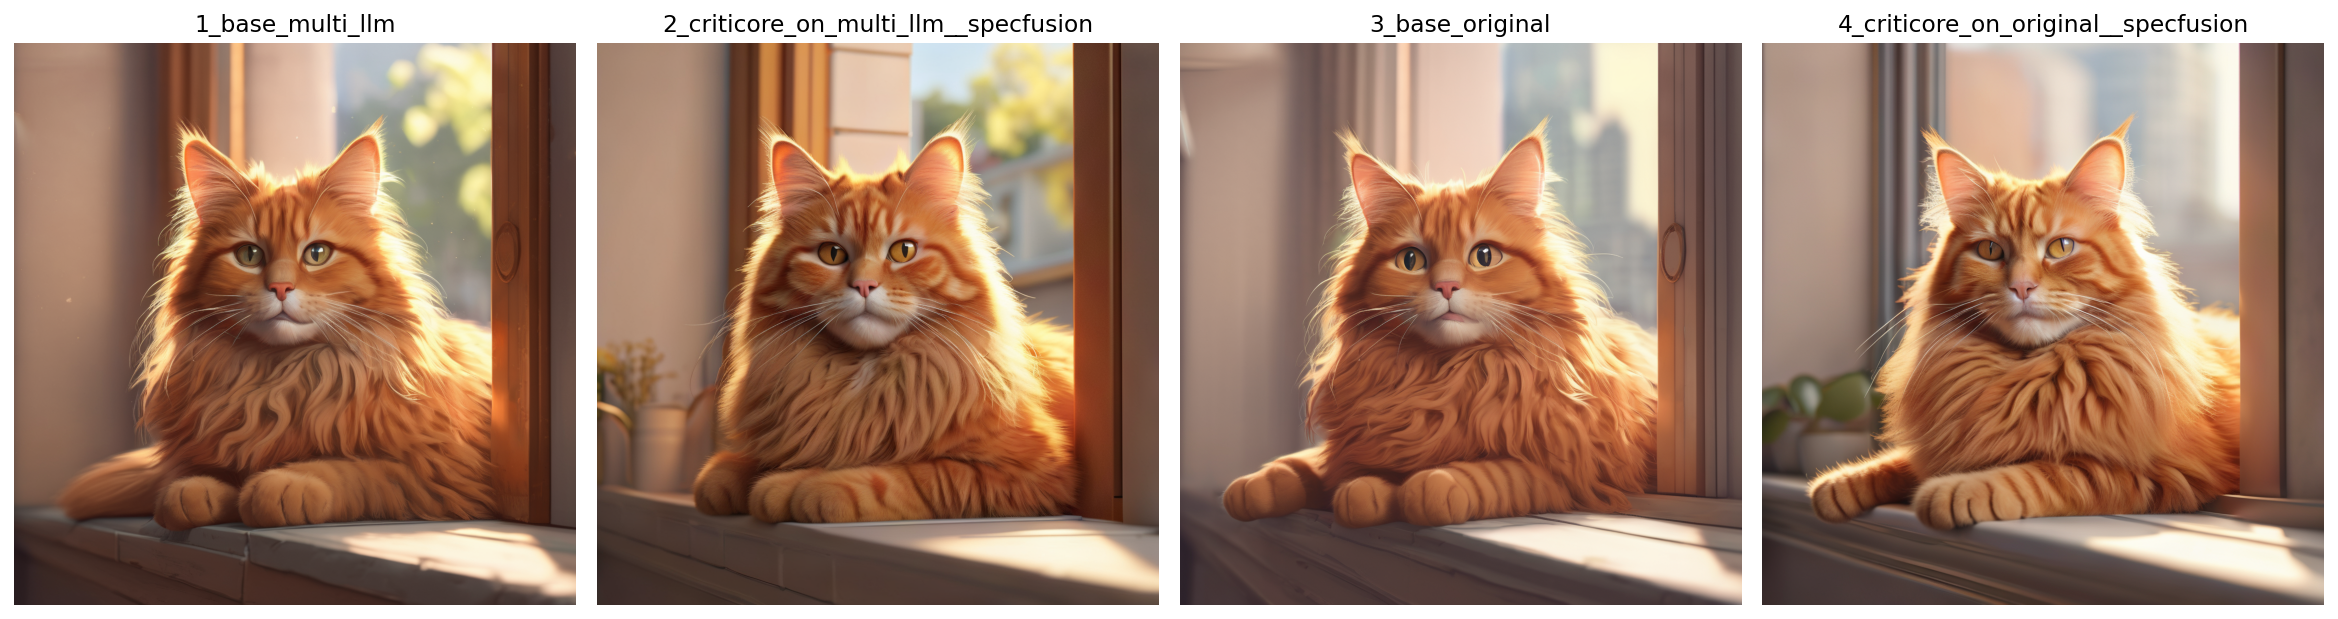


All prompts finished. Outputs saved under: C:\Users\zqche\Downloads\variants_demo4


In [ ]:

#==== Minimal main (example) ====
#Requires: CritiCore, strength_for_last_k, img2img_latent, frequency_fusion,
#         cadr_from_alignment, decode_image_sdxl, DEFAULT_NEG, SDXL_i2i, DEVICE, pref_score

#Example usage:
OUT_DIR = Path("./variants_demo4")
ENABLED_VARIANTS = [
    "base_original",
    "base_multi_llm",
    "criticore_on_original__specfusion",
    "criticore_on_multi_llm__specfusion",
]
SEED = 2026; H, W = 1024, 1024; PRESET = "hq_preference"
PROMPTS = [
        "A fluffy orange cat lying on a window ledge, front-facing, stylized in 3D Pixar look, soft indoor lighting",
]

async def run_all():
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    for i, prompt in enumerate(PROMPTS, 1):
        dst = OUT_DIR / f"prompt_{i:02d}"
        print(f"\n===== Running Prompt {i} / {len(PROMPTS)} =====")
        print("Prompt:", prompt)
        results = await generate_variants(
            user_prompt=prompt,
            seed=SEED,
            H=H, W=W,
            total_steps_refine=50,      # denominator for strength_for_last_k
            last_k_list=(37,),          # choose k; here we use 36
            guidance_list=None,
            preset=PRESET,
            out_dir=dst,
            enabled_variants=ENABLED_VARIANTS,
        )
        visualize_variants(results, dpi=140, title=None)
    print("\nAll prompts finished. Outputs saved under:", OUT_DIR.resolve())

# Jupyter: await run_all()
if __name__ == "__main__":
    asyncio.run(run_all())
